In [1]:
pip install praw textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.2 MB/s eta 0:00:00


In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


# Bitcoin sentiment with Vader

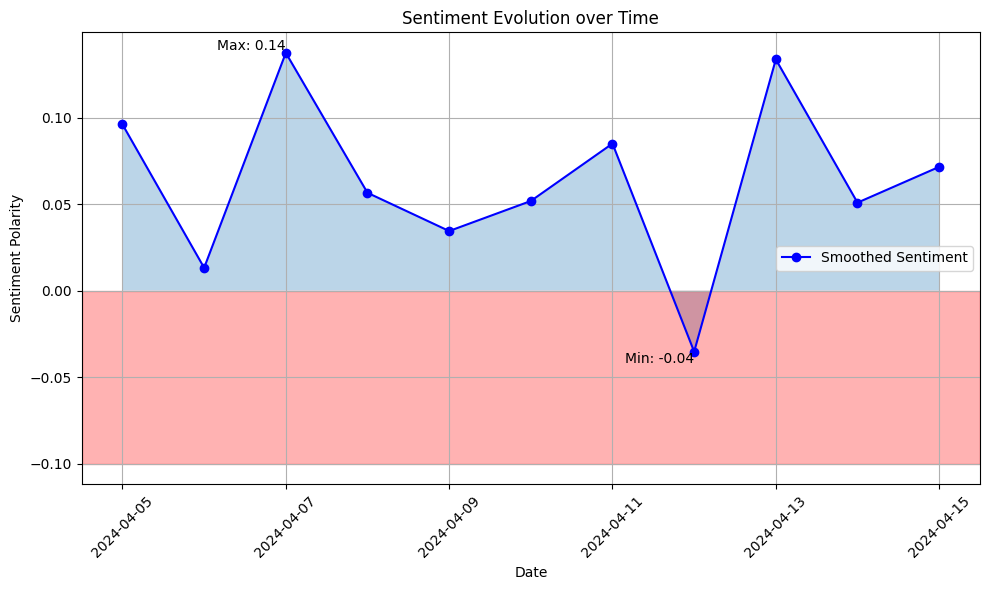

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.interpolate import interp1d

# Read the CSV file into a DataFrame
reddit_data = pd.read_csv('reddit_12_april.csv')

# Convert 'Timestamp' column to datetime format
reddit_data['Timestamp'] = pd.to_datetime(reddit_data['Timestamp'])

# Initialize a list to store timestamp and sentiment
data = []

analyzer = SentimentIntensityAnalyzer()

for index, row in reddit_data.iterrows():
    title_sentiment = analyzer.polarity_scores(row['Title'])
    data.append([row['Timestamp'], title_sentiment['compound']])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Timestamp', 'Polarity'])

# Convert the timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Aggregate data by day and calculate average polarity
daily_sentiment = df.resample('D', on='Timestamp').mean()

# Interpolate the data
interpolator = interp1d(daily_sentiment.index.astype(int), daily_sentiment['Polarity'], kind='linear')
interpolated_index = pd.date_range(start=daily_sentiment.index.min(), end=daily_sentiment.index.max(), freq='1D')
interpolated_values = interpolator(interpolated_index.astype(int))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(interpolated_index, interpolated_values, marker='o', linestyle='-', color='b', label='Smoothed Sentiment')
plt.title('Sentiment Evolution over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.grid(True)

# Add confidence interval
plt.fill_between(interpolated_index, interpolated_values, alpha=0.3)

# Add max and min markers
max_idx = interpolated_values.argmax()
min_idx = interpolated_values.argmin()
plt.text(interpolated_index[max_idx], interpolated_values[max_idx], f'Max: {interpolated_values[max_idx]:.2f}', ha='right', va='bottom')
plt.text(interpolated_index[min_idx], interpolated_values[min_idx], f'Min: {interpolated_values[min_idx]:.2f}', ha='right', va='top')

# Shade the area where sentiment polarity is below 0 (negative events)
plt.axhspan(ymin=0, ymax=-0.1, color='red', alpha=0.3)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

# Bitcoin sentiment with TextBlob

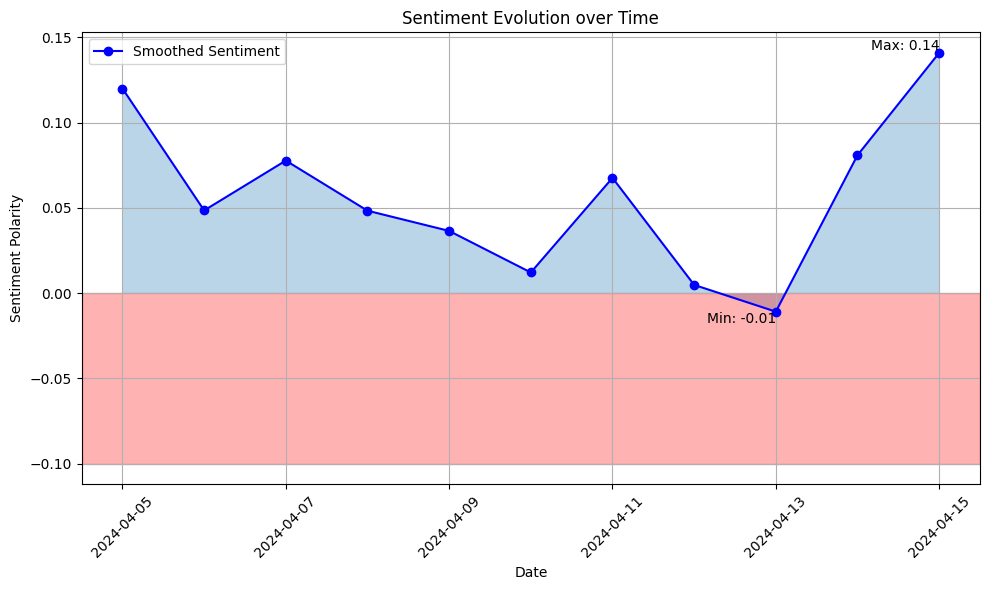

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from scipy.interpolate import interp1d

# Read the CSV file into a DataFrame
reddit_data = pd.read_csv('reddit_12_april.csv')

# Convert 'Timestamp' column to datetime format
reddit_data['Timestamp'] = pd.to_datetime(reddit_data['Timestamp'])

# Initialize a list to store timestamp and sentiment
data = []

# Analyze the sentiment of each title and append the data
for index, row in reddit_data.iterrows():
    title_sentiment = TextBlob(row['Title']).sentiment.polarity
    data.append([row['Timestamp'], title_sentiment])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Timestamp', 'Polarity'])

# Convert the timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Aggregate data by day and calculate average polarity
daily_sentiment = df.resample('D', on='Timestamp').mean()

# Ensure there's no missing data for interpolation
daily_sentiment = daily_sentiment.interpolate(method='linear')

# Interpolate the data
interpolator = interp1d(daily_sentiment.index.astype(int), daily_sentiment['Polarity'], kind='linear', fill_value='extrapolate')
interpolated_index = pd.date_range(start=daily_sentiment.index.min(), end=daily_sentiment.index.max(), freq='1D')
interpolated_values = interpolator(interpolated_index.astype(int))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(interpolated_index, interpolated_values, marker='o', linestyle='-', color='b', label='Smoothed Sentiment')
plt.title('Sentiment Evolution over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.grid(True)

# Add confidence interval (Shading)
plt.fill_between(interpolated_index, interpolated_values, alpha=0.3)

# Add max and min markers
max_idx = interpolated_values.argmax()
min_idx = interpolated_values.argmin()
plt.text(interpolated_index[max_idx], interpolated_values[max_idx], f'Max: {interpolated_values[max_idx]:.2f}', ha='right', va='bottom')
plt.text(interpolated_index[min_idx], interpolated_values[min_idx], f'Min: {interpolated_values[min_idx]:.2f}', ha='right', va='top')

# Shade the area where sentiment polarity is below 0 (negative events)
plt.axhspan(ymin=0, ymax=-0.1, color='red', alpha=0.3)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
import datetime
import praw

# Initialize PRAW with credentials
reddit = praw.Reddit(
    client_id="Ekavzy0B2XaBc2hCdVHv2g",
    client_secret="A71PdlgcAZJMO-DNT21mXw7NDZZ_qQ",
    user_agent="u/Foreign-Nectarine150",
    check_for_async=False,
)

subreddit = reddit.subreddit("bitcoin+ETF")

bitcoinETFs = [*subreddit.top(limit=None)]

print(len(bitcoinETFs))

# Create lists of the information from each news
title = [bitcoinETF.title for bitcoinETF in bitcoinETFs]

bitcoinETFNews = pd.DataFrame({
    "Title": title,
})
bitcoinETFNews.tail()

994


,Title
989,"BREAKING NEWS: Despite unprecedented demand, B..."
990,This is getting too much...
991,I found this wallet.dat file on an old laptop.
992,ETF Portfolio Design
993,"Where are business obligations, like a propert..."


In [11]:
sid = SentimentIntensityAnalyzer()

res = [*bitcoinETFNews['Title'].apply(sid.polarity_scores)]
print(res[:6])

sentiment_df = pd.DataFrame.from_records(res)
bitcoinETFNews = pd.concat([bitcoinETFNews, sentiment_df], axis=1, join='inner')

# Take the last 10 elements
last_10_news = bitcoinETFNews.tail(10)

# Display the last 10 elements
print(last_10_news)

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.885, 'pos': 0.115, 'compound': 0.3818}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'compound': -0.2732}]
                                                 Title    neg    neu    pos  \
984             Central banks doing what they do best.  0.000  0.588  0.412   
985                 Bitcoin takes a walk with Dogecoin  0.000  1.000  0.000   
986  Cathie Wood Ark CEO: Bitcoin is the "Best Hedg...  0.000  0.693  0.307   
987  BitMex has just liquidated and distributed the...  0.000  1.000  0.000   
988       So i found an old bitcoin wallet from 2009!   0.000  1.000  0.000   
989  BREAKING NEWS: Despite unprecedented demand, B...  0.000  0.748  0.252   
990                       This is getting too much...   0.000  1.000  0.000   
991     I found this w

In [12]:
import numpy as np

THRESHOLD = 0.05

conditions = [
    (bitcoinETFNews['compound'] <= -THRESHOLD),
    (bitcoinETFNews['compound'] > -THRESHOLD) & (bitcoinETFNews['compound'] < THRESHOLD),
    (bitcoinETFNews['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
bitcoinETFNews['Label'] = np.select(conditions, values)

bitcoinETFNews.tail()

,Title,neg,neu,pos,compound,Label
989,"BREAKING NEWS: Despite unprecedented demand, B...",0.000,0.748,0.252,0.2584,pos
990,This is getting too much...,0.000,1.000,0.000,0.0000,neu
991,I found this wallet.dat file on an old laptop.,0.000,1.000,0.000,0.0000,neu
992,ETF Portfolio Design,0.000,1.000,0.000,0.0000,neu
993,"Where are business obligations, like a propert...",0.156,0.688,0.156,0.0000,neu


In [13]:
bitcoinETFNews.Label.value_counts()

Label
neu    524
pos    325
neg    145
Name: count, dtype: int64

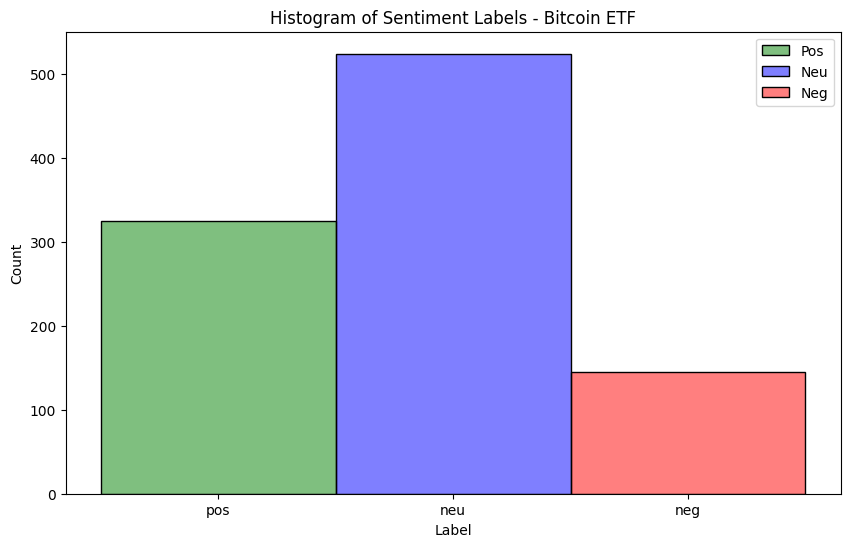

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors for each sentiment label
label_colors = {'pos': 'green', 'neu': 'blue', 'neg': 'red'}

# Plot histograms for each sentiment label
plt.figure(figsize=(10, 6))

sns.histplot(data=bitcoinETFNews[bitcoinETFNews['Label'] == 'pos'], x='Label', color=label_colors['pos'], label='Pos', alpha=0.5)
sns.histplot(data=bitcoinETFNews[bitcoinETFNews['Label'] == 'neu'], x='Label', color=label_colors['neu'], label='Neu', alpha=0.5)
sns.histplot(data=bitcoinETFNews[bitcoinETFNews['Label'] == 'neg'], x='Label', color=label_colors['neg'], label='Neg', alpha=0.5)

plt.title('Histogram of Sentiment Labels - Bitcoin ETF')
plt.xlabel('Label')
plt.ylabel('Count')

plt.legend()
plt.show()